In [ ]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import ExpectationMaximization
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD

# (1) 数据预处理 - 修改后的版本，不进行离散化
def preprocess_image(image):
    """
    将图像直接展平为一个向量。
    """
    return image.flatten()

# 辅助函数：生成二维高斯核
def gaussian_kernel(x, y, sigma, grid_size):
    """
    生成二维高斯核函数。
    """
    grid_x, grid_y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
    kernel = np.exp(-((grid_x - x)**2 + (grid_y - y)**2) / (2 * sigma**2))
    return kernel

# 生成模拟数据
np.random.seed(42)
num_samples = 10
grid_size = 10
data = []
max_num_sources = 5
for _ in range(num_samples):

    image = np.zeros((grid_size, grid_size))
    num_sources = np.random.poisson(lam=3)  
    source_info = []  
    for _ in range(num_sources):
        x, y = np.random.randint(0, grid_size, size=2)  
        flux = np.random.normal(loc=0.5, scale=0.1)  
        flux_level = np.digitize(flux, bins=[0, 0.3, 0.7, 1]) - 1 
        kernel = gaussian_kernel(x, y, sigma=1, grid_size=grid_size)
        image += flux * kernel
        source_info.append((x, y, flux_level)) 
    
    regions = preprocess_image(image)
    
   
    sample = list(regions) 
    sample = [num_sources] + sample  
    for i in range(max_num_sources):  
        if i < len(source_info):
            sample.extend([source_info[i][0], source_info[i][1], source_info[i][2]])
        else:
            sample.extend([0, 0, 0]) 

    data.append(sample)


columns = ["N"] + [f"R{i}" for i in range(grid_size*grid_size)]  # 区域强度
source_columns = [item for i in range(max_num_sources) for item in (f"X{i}", f"Y{i}", f"F{i}")]  # 每个源的位置和 flux 等级
df = pd.DataFrame(data, columns=columns + source_columns)

# (2) 构建贝叶斯网络 - 保持不变
model = BayesianModel()
model.add_nodes_from(columns + source_columns)

# 更新边的定义，因为现在我们有一个一维的区域列表而不是二维网格
model.add_edges_from([('N', region) for region in columns[1:]])  # 源数量影响区域强度
model.add_edges_from([(f"X{i}", region) for i in range(max_num_sources) for region in columns[1:]])  # 源位置影响区域强度
model.add_edges_from([(f"Y{i}", region) for i in range(max_num_sources) for region in columns[1:]])  # 源位置影响区域强度
model.add_edges_from([(f"F{i}", region) for i in range(max_num_sources) for region in columns[1:]])  # 源 flux 影响区域强度

cpd_n = TabularCPD(variable='N', variable_card=6, values=[[0.2]]*6)  
cpd_x0 = TabularCPD(variable='X0', variable_card=grid_size, values=[[1/grid_size]]*grid_size)  
cpd_y0 = TabularCPD(variable='Y0', variable_card=grid_size, values=[[1/grid_size]]*grid_size)
cpd_f0 = TabularCPD(variable='F0', variable_card=3, values=[[0.3], [0.4], [0.3]])  

model.add_cpds(cpd_n, cpd_x0, cpd_y0, cpd_f0)

# (3) 参数学习
model.fit(df, estimator=ExpectationMaximization)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Inference Result: {'Y4': 0, 'Y1': 4, 'F3': 1, 'F4': 0, 'X1': 5, 'X3': 4, 'Y3': 0, 'F2': 1, 'Y2': 7, 'F0': 1, 'F1': 1, 'Y0': 6, 'X4': 0, 'X2': 1, 'X0': 2}


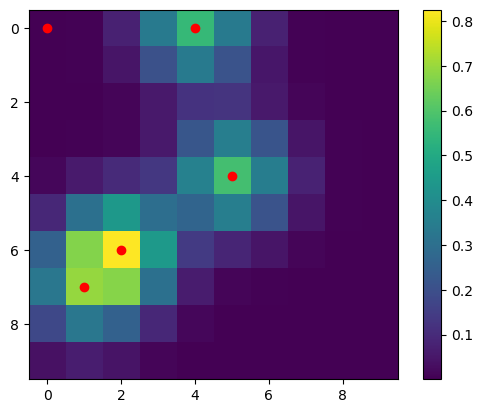

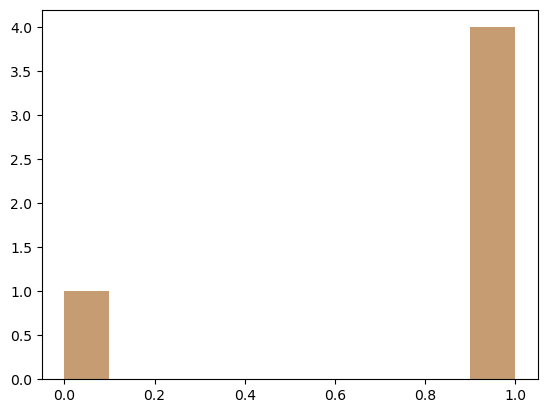

In [25]:
# 假设model已经被正确地定义和训练

# 生成模拟测试数据
image = np.zeros((grid_size, grid_size))
num_sources = 3
for i in range(num_sources):
    x, y = np.random.randint(0, grid_size, size=2)
    flux = np.random.normal(loc=0.5, scale=0.1)
    kernel = gaussian_kernel(x, y, sigma=1, grid_size=grid_size)
    image += flux * kernel
    
regions = preprocess_image(image)

sample = list(regions)
sample = [num_sources] + sample

# 确保这里使用的x, y, flux对应于每个源的信息
for i in range(max_num_sources):
    if i < num_sources:
        sample.extend([x, y, flux])
    else:
        sample.extend([0, 0, 0])

test_data = pd.DataFrame([sample], columns=columns + source_columns)

# 使用VariableElimination进行推断
inference = VariableElimination(model)

# 构建evidence字典，注意这里的key应该是在模型中存在的变量名
evidence_dict = {f"R{i}": df.iloc[0][f"R{i}"] for i in range(grid_size*grid_size)}

evidence_dict
# 执行MAP查询

result = inference.map_query(variables=source_columns, evidence=evidence_dict)
print("Inference Result:", result)

# 可视化结果
import matplotlib.pyplot as plt
plt.imshow(df.iloc[0][columns[1:]].values.reshape(grid_size, grid_size))
plt.colorbar()

x = [result[f"X{i}"] for i in range(max_num_sources) if f"X{i}" in result]
y = [result[f"Y{i}"] for i in range(max_num_sources) if f"Y{i}" in result]

plt.scatter(x, y, color='red')

plt.show()

# flux 等级的直方图
plt.hist(df.iloc[0][source_columns[2::3]], alpha=0.5, label='True')
plt.hist([result[f"F{i}"] for i in range(max_num_sources) if f"F{i}" in result], alpha=0.5, label='Predicted')
plt.show()



In [21]:
# 假设 model 是你的贝叶斯网络模型
for var in ["R00", "R01", "R02"]:
    print(f"Variable {var} has states: {model.get_cpds(var).state_names}")

Variable R00 has states: {'R00': [0], 'F0': [1], 'F1': [1], 'F2': [1], 'F3': [0, 1], 'F4': [0], 'N': [3, 4], 'X0': [2, 9], 'X1': [5, 8], 'X2': [1, 4], 'X3': [0, 4], 'X4': [0], 'Y0': [2, 6], 'Y1': [2, 4], 'Y2': [2, 7], 'Y3': [0], 'Y4': [0]}
Variable R01 has states: {'R01': [0], 'F0': [1], 'F1': [1], 'F2': [1], 'F3': [0, 1], 'F4': [0], 'N': [3, 4], 'X0': [2, 9], 'X1': [5, 8], 'X2': [1, 4], 'X3': [0, 4], 'X4': [0], 'Y0': [2, 6], 'Y1': [2, 4], 'Y2': [2, 7], 'Y3': [0], 'Y4': [0]}
Variable R02 has states: {'R02': [0], 'F0': [1], 'F1': [1], 'F2': [1], 'F3': [0, 1], 'F4': [0], 'N': [3, 4], 'X0': [2, 9], 'X1': [5, 8], 'X2': [1, 4], 'X3': [0, 4], 'X4': [0], 'Y0': [2, 6], 'Y1': [2, 4], 'Y2': [2, 7], 'Y3': [0], 'Y4': [0]}
